<a href="https://colab.research.google.com/github/sayalaruano/MidtermProject-MLZoomCamp/blob/main/EDA_beta_lactamase_drug_discovery_project_version3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDA of Beta-Lactamases drug discovery project**

Sebastián Ayala Ruano

This [video](https://youtu.be/_GtEgiWWyK4) has more information about the project and how to collaborate in it.

## **Installation of libraries and mounting drive**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("drive/MyDrive/MLZoomcamp/MidtermProject-MLZoomCamp-main")

In [ ]:
!pip install padelpy

     |████████████████████████████████| 20.9 MB 1.4 MB/s 


In [ ]:
! pip install scikit-learn==1

     |████████████████████████████████| 23.1 MB 61.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## **Imports and data obtention**

In [ ]:
# Import libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from padelpy import padeldescriptor
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
# Download data
! mkdir Data 
! wget https://github.com/dataprofessor/beta-lactamase/raw/main/beta_lactamase_CHEMBL29.zip --directory ./Data

--2021-10-22 16:49:42--  https://github.com/dataprofessor/beta-lactamase/raw/main/beta_lactamase_CHEMBL29.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/beta-lactamase/main/beta_lactamase_CHEMBL29.zip [following]
--2021-10-22 16:49:43--  https://raw.githubusercontent.com/dataprofessor/beta-lactamase/main/beta_lactamase_CHEMBL29.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1416390 (1.4M) [application/zip]
Saving to: ‘./Data/beta_lactamase_CHEMBL29.zip’

beta_lactamase_CHEM 100%[===================>]   1.35M  3.69MB/s    in 0.4s    

2021-10-22 16:49:43 (3.69 MB/s) - ‘./D

In [ ]:
# Concatenate all cv files from zip file into a single unified dataframe
zf = zipfile.ZipFile("Data/beta_lactamase_CHEMBL29.zip", "r")
df = pd.concat( (pd.read_csv( zf.open(f) ) for f in zf.namelist() ) )

In [ ]:
# Take a look at the dataframe
df

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label
0,CHEMBL1730,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(COC(C)...,=,10.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
1,CHEMBL996,CO[C@@]1(NC(=O)Cc2cccs2)C(=O)N2C(C(=O)O)=C(COC...,NaN,NaN,NaN,Kcat/Km,NaN,Gil1,assay format
2,CHEMBL617,CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)Cc3ccc...,=,598.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
3,CHEMBL702,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3[C@@H...,=,3400.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
4,CHEMBL1449,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](C(=O)O)c3ccsc3...,=,10000.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
...,...,...,...,...,...,...,...,...,...
13,CHEMBL561555,COC(=O)CC(N)(CC(=O)OC)C(=O)OCc1ccccc1,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
14,CHEMBL561821,NC(CC(=O)OCc1ccccc1)(CC(=O)OCc1ccccc1)C(=O)OCc...,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
15,CHEMBL561896,COC(=O)CC(CC(=O)OC)(NC(=O)Cc1ccccc1)C(=O)OC,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
16,CHEMBL563044,COC(=O)C(CC(=O)OCc1ccccc1)(CC(=O)OCc1ccccc1)NC...,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format


## **Exploratory Data Analysis**

In [ ]:
# General measurements of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71973 entries, 0 to 17
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  71973 non-null  object 
 1   canonical_smiles    71937 non-null  object 
 2   standard_relation   70934 non-null  object 
 3   standard_value      71185 non-null  float64
 4   standard_units      70521 non-null  object 
 5   standard_type       71969 non-null  object 
 6   pchembl_value       64424 non-null  float64
 7   target_pref_name    71973 non-null  object 
 8   bao_label           71973 non-null  object 
dtypes: float64(2), object(7)
memory usage: 5.5+ MB


### **Target variable: pCHEMBL value**

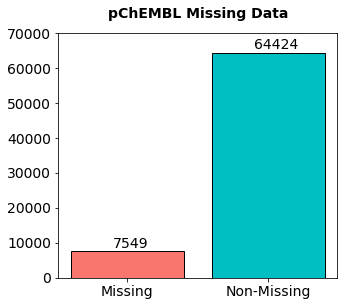

In [ ]:
# Bar plot of Missing vs Non-Missing Data of pCHEMBL values

# Data
missing = df.pchembl_value.isnull().sum()
nonmissing = df.pchembl_value.notnull().sum()

x = ['Missing', 'Non-Missing']
y = [missing, nonmissing]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('pChEMBL Missing Data', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

ax.set_ylim(0,70000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

In [ ]:
# Dataset with non-missing pChEMBL values
df2 = df[df.pchembl_value.notnull()]

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64424 entries, 47 to 109
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  64424 non-null  object 
 1   canonical_smiles    64408 non-null  object 
 2   standard_relation   64424 non-null  object 
 3   standard_value      64424 non-null  float64
 4   standard_units      64424 non-null  object 
 5   standard_type       64424 non-null  object 
 6   pchembl_value       64424 non-null  float64
 7   target_pref_name    64424 non-null  object 
 8   bao_label           64424 non-null  object 
dtypes: float64(2), object(7)
memory usage: 4.9+ MB


In [ ]:
# Verify duplicated molecules by ChEMBL ID
print('Number of unique ChEMBL ID:', str(len(df2.molecule_chembl_id.unique()) )  )
print('Total number of ChEMBL ID: ', str(len(df2)))

Number of unique ChEMBL ID: 63038
Total number of ChEMBL ID:  64424


I will use a function to replace duplicated molecules by one single row with mean of standard_value and pchembl_value of duplicated rows. The replacement is applied only if standard deviation of pchembl_value is lower than 2.

In [ ]:
def combine_molecule_duplicates(dataset):
    '''
    Function to replace duplicated molecules by one single row with mean of standard_value and 
    pchembl_value of duplicated rows. The replacement is applied only if standard deviation of 
    pchembl_value is lower than 2.

        Parameters:
            dataset (DataFrame): A pandas DataFrame with duplicated molecules
        
        Returns: 
            dataset (DataFrame): A pandas DataFrame without duplicated molecules
    '''
    # Calculate standard deviation of all molecules
    std_by_uniqueID = dataset.groupby("molecule_chembl_id").std()

    # Filter standard deviation of duplicated molecules lower than 2
    std_by_uniqueID = std_by_uniqueID[std_by_uniqueID.pchembl_value < 2]

    # Calculate mean of all molecules
    mean_by_uniqueID = dataset.groupby("molecule_chembl_id").mean()
    
    # Filter mean of duplicated molecules that have standard deviation lower than 2
    mean_by_uniqueID = mean_by_uniqueID.filter(items = std_by_uniqueID.index, axis=0)

    # Create a dictionary of rows with mean values of standard_value and pchembl_value
    new_rows = {}

    for i in mean_by_uniqueID.index:
        rows = dataset.loc[dataset.molecule_chembl_id == i].copy()
        row = rows.iloc[0].copy()
        row.standard_value = mean_by_uniqueID.loc[i].standard_value
        row.pchembl_value = mean_by_uniqueID.loc[i].pchembl_value
        new_rows[i] = row
    
    # Convert dictionary to dataframa
    df_new_rows = pd.DataFrame(new_rows).T
    
    # Delete duplicated molecules from the original dataset
    dataset = dataset.drop_duplicates(subset=["molecule_chembl_id"], keep=False)

    # Add new rows to the original dataset
    dataset = pd.concat([dataset, df_new_rows], axis=0).reset_index(drop=True)

    return dataset

In [ ]:
# Replace duplicated molecules by mean of their standard_value and pchembl_value
df2_non_duplic = combine_molecule_duplicates(df2)

In [ ]:
# Cast pchembl and standard values from object to float 
cast_types = {'standard_value': np.float, 'pchembl_value': np.float}

df2_non_duplic = df2_non_duplic.astype(cast_types)

In [ ]:
df2_non_duplic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63030 entries, 0 to 63029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  63030 non-null  object 
 1   canonical_smiles    63014 non-null  object 
 2   standard_relation   63030 non-null  object 
 3   standard_value      63030 non-null  float64
 4   standard_units      63030 non-null  object 
 5   standard_type       63030 non-null  object 
 6   pchembl_value       63030 non-null  float64
 7   target_pref_name    63030 non-null  object 
 8   bao_label           63030 non-null  object 
dtypes: float64(2), object(7)
memory usage: 4.3+ MB


In [ ]:
# Verify that duplicates were deleted 
print('Number of unique ChEMBL ID:', str(len(df2_non_duplic.molecule_chembl_id.unique()) )  )
print('Total number of ChEMBL ID: ', str(len(df2_non_duplic)) )

Number of unique ChEMBL ID: 63030
Total number of ChEMBL ID:  63030


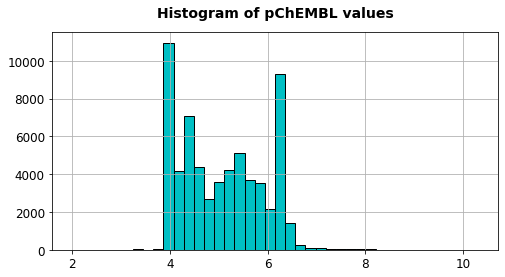

In [ ]:
# Distribution of pchembl_values
df2_non_duplic.pchembl_value.hist(bins=40, figsize=(8,4), color='#00BFC4', ec='black')

plt.title('Histogram of pChEMBL values', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The histogram shows that distribution of this variable has a normal shape, which is because the formula of this coefficient includes log10, so there is no need to apply a transformation in this feature.

In [ ]:
# Convert pchembl values to binary 
# 0 means that molecules are inactive and 1 that they are active 
df2_non_duplic["pchembl_bin"] = (df2_non_duplic["pchembl_value"] >= 5).astype(int)

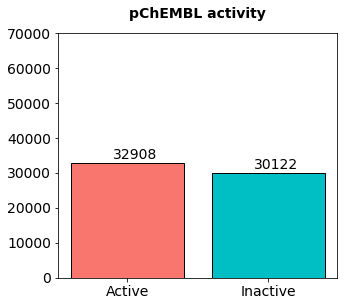

In [ ]:
# Bar plot of active and inactive molecules considering pCHEMBL values

# Data
active = len(df2_non_duplic[df2_non_duplic.pchembl_bin == 1])
inactive = len(df2_non_duplic[df2_non_duplic.pchembl_bin == 0])

x = ['Active', 'Inactive']
y = [active, inactive]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('pChEMBL activity', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

ax.set_ylim(0,70000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

We observed that the dataset is not unbalanced regarding pchemb_bin values

Also, I will use a modified version of the function to calculate Mann-Whitney U Test provided by data professor in [this notebook](https://github.com/dataprofessor/code/blob/master/python/CDD_ML_Part_2_Exploratory_Data_Analysis.ipynb). This test will be used for calculating if there are statistical significance differences between active and inactive categories regarding pchembl value.

In [ ]:
# Statistical analysis | Mann-Whitney U Test
def mannwhitney(descriptor, dataset, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

# seed the random number generator
  np.random.seed(1)

# actives and inactives
  selection = [descriptor, 'pchembl_bin']
  df = dataset[selection]
  active = df[df.pchembl_bin == 1]
  active = active[descriptor]

  inactive = df[df.pchembl_bin == 0]
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])

  return results

In [ ]:
mannwhitney('pchembl_value', df2_non_duplic)

,Descriptor,Statistics,p,alpha,Interpretation
0,pchembl_value,0.0,0.0,0.05,Different distribution (reject H0)


We observed that distributions of active and inactive compounds in terms of pchembl value are statistically different.

### **Other features**

In [ ]:
# Get rid of molecules without canonical simles 
df3 = df2_non_duplic[df2_non_duplic.canonical_smiles.notnull()]

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63014 entries, 0 to 63029
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  63014 non-null  object 
 1   canonical_smiles    63014 non-null  object 
 2   standard_relation   63014 non-null  object 
 3   standard_value      63014 non-null  float64
 4   standard_units      63014 non-null  object 
 5   standard_type       63014 non-null  object 
 6   pchembl_value       63014 non-null  float64
 7   target_pref_name    63014 non-null  object 
 8   bao_label           63014 non-null  object 
 9   pchembl_bin         63014 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 5.3+ MB


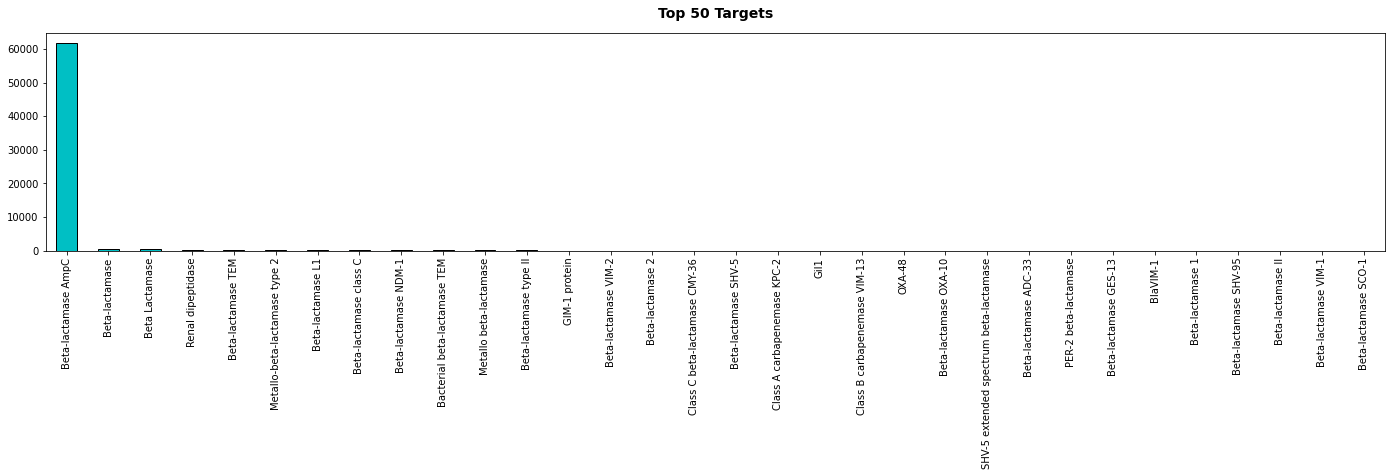

In [ ]:
# Distribution of target proteins  
df3.target_pref_name.value_counts()[0:50].plot.bar(figsize=(24,4), color='#00BFC4', ec='black')

plt.title('Top 50 Targets', fontsize=14, fontweight='black', pad=15)
plt.show()

In [ ]:
# Filter only molecules tested on Beta-lactamase AmpC
df4 = df3[df3.target_pref_name == "Beta-lactamase AmpC"].reset_index(drop=True)
df4 = df4.sort_values("molecule_chembl_id").reset_index(drop=True)

In [ ]:
# Delete CHEMBL412073 moecule because it is not possible to calculate fingerprints of it 
df4 = df4.drop(labels = [61151]).reset_index(drop=True)

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61736 entries, 0 to 61735
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  61736 non-null  object 
 1   canonical_smiles    61736 non-null  object 
 2   standard_relation   61736 non-null  object 
 3   standard_value      61736 non-null  float64
 4   standard_units      61736 non-null  object 
 5   standard_type       61736 non-null  object 
 6   pchembl_value       61736 non-null  float64
 7   target_pref_name    61736 non-null  object 
 8   bao_label           61736 non-null  object 
 9   pchembl_bin         61736 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 4.7+ MB


We observed that there are not null values in any feature of the dataset

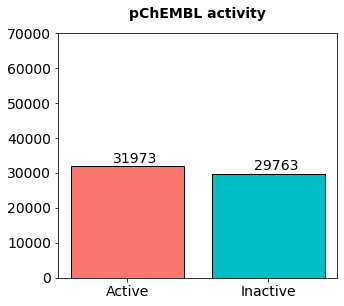

In [ ]:
# Bar plot of active and inactive molecules considering pCHEMBL values of Beta-lactamase AmpC target

# Data
active = len(df4[df4.pchembl_bin == 1])
inactive = len(df4[df4.pchembl_bin == 0])

x = ['Active', 'Inactive']
y = [active, inactive]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('pChEMBL activity', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

ax.set_ylim(0,70000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

We observed that the balance proportion was maintained after filtering molecules that bind to Beta-lactamase AmpC

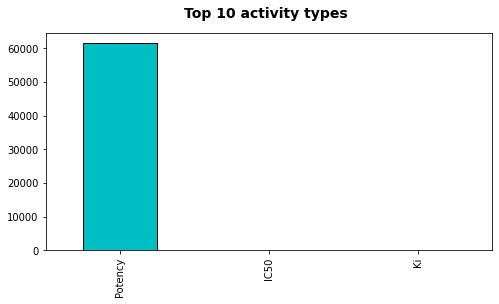

In [ ]:
# Top 10 activity types 
df4.standard_type.value_counts()[:10].plot.bar(figsize=(8,4), color='#00BFC4', ec='black')

plt.title('Top 10 activity types ', fontsize=14, fontweight='black', pad=15)
plt.show()

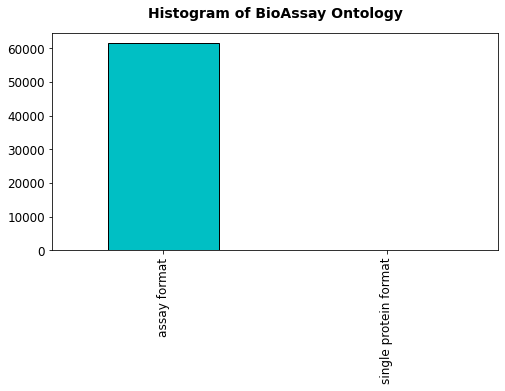

In [ ]:
# Histogram of BioAssay Ontology
bao_labels = df4.bao_label.value_counts()
bao_labels.plot.bar(figsize=(8,4), color='#00BFC4', ec='black')

plt.title('Histogram of BioAssay Ontology', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### **Calculation of molecular descriptors from SMILES with PaDEL**

#### **Preparation of files to calculate molecular descriptors**
To make this step yo need to install Padelpy library with pip, as follows: 

```python
pip install padelpy

```

In [ ]:
# Download and unzip fingerprint XML files
! mkdir Data/MolFingerprints
! wget https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip --directory ./Data/MolFingerprints
! unzip Data/MolFingerprints/fingerprints_xml.zip -d Data/MolFingerprints

mkdir: cannot create directory ‘Data/MolFingerprints’: File exists
--2021-10-23 15:12:56--  https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip [following]
--2021-10-23 15:12:57--  https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10871 (11K) [application/zip]
Saving to: ‘./Data/MolFingerprints/fingerprints_xml.zip.1’

fingerprints_xml.zi 100%[===================>]  10.62K  --.-KB/s    in 0.002s  

2021-10-23 

In [ ]:
# List and sort fingerprint XML files
xml_files = glob.glob("Data/MolFingerprints/*.xml")
xml_files.sort()
xml_files.remove("Data/MolFingerprints/KlekotaRothFingerprintCount.xml")
xml_files.remove("Data/MolFingerprints/KlekotaRothFingerprinter.xml")
xml_files

['Data/MolFingerprints/AtomPairs2DFingerprintCount.xml',
 'Data/MolFingerprints/AtomPairs2DFingerprinter.xml',
 'Data/MolFingerprints/EStateFingerprinter.xml',
 'Data/MolFingerprints/ExtendedFingerprinter.xml',
 'Data/MolFingerprints/Fingerprinter.xml',
 'Data/MolFingerprints/GraphOnlyFingerprinter.xml',
 'Data/MolFingerprints/MACCSFingerprinter.xml',
 'Data/MolFingerprints/PubchemFingerprinter.xml',
 'Data/MolFingerprints/SubstructureFingerprintCount.xml',
 'Data/MolFingerprints/SubstructureFingerprinter.xml']

In [ ]:
# Create a list with shorten names of xml files
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [ ]:
# Create a dictionary with shorten names as keys and xml file names as values
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'Data/MolFingerprints/AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'Data/MolFingerprints/AtomPairs2DFingerprinter.xml',
 'EState': 'Data/MolFingerprints/EStateFingerprinter.xml',
 'CDKextended': 'Data/MolFingerprints/ExtendedFingerprinter.xml',
 'CDK': 'Data/MolFingerprints/Fingerprinter.xml',
 'CDKgraphonly': 'Data/MolFingerprints/GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'Data/MolFingerprints/KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'Data/MolFingerprints/KlekotaRothFingerprinter.xml',
 'MACCS': 'Data/MolFingerprints/MACCSFingerprinter.xml',
 'PubChem': 'Data/MolFingerprints/PubchemFingerprinter.xml',
 'SubstructureCount': 'Data/MolFingerprints/SubstructureFingerprintCount.xml',
 'Substructure': 'Data/MolFingerprints/SubstructureFingerprinter.xml'}

In [ ]:
# Prepare data subset as input to PaDELpy
df_padelpy = pd.concat( [df4['canonical_smiles'], df4['molecule_chembl_id']], axis=1 )
df_padelpy.to_csv('molecule.smi', sep='\t', index=False, header=False)
df_padelpy

,canonical_smiles,molecule_chembl_id
295,COC1=CC2CC(=O)N(C2)C1C(=O)OCc1ccc([N+](=O)[O-]...,CHEMBL606647
296,CC1(C)S[C@@H]2[C@@H](CO)C(=O)N2[C@H]1C(=O)O,CHEMBL277857
297,CC[C@@H]1C(=O)N2C[C@@H]1CC(OC)=C2C(=O)O,CHEMBL84953
298,C[C@H](O)[C@H]1C(=O)N2[C@@H](C(=O)[O-])C(C)(C)...,CHEMBL177772
299,C[C@H](O)[C@@H]1C(=O)N2[C@@H](C(=O)[O-])C(C)(C...,CHEMBL175189
...,...,...
63006,C[C@]1(Cn2ccnn2)[C@H](C(=O)[O-])N2C(=O)[C@@H](...,CHEMBL6533
63007,CO/N=C/[C@@]1(C)[C@H](C(=O)[O-])N2C(=O)[C@@H](...,CHEMBL6678
63013,O=C(O)c1ccccn1,CHEMBL72628
63017,O=C(O)c1ccc(B(O)O)cc1,CHEMBL82324


#### **Calculate descriptors**
We calculated only 10 descriptors. KlekotaRoth and KlekotaRothCount fingerprints were excluded because they required a long time to be obtained. The output data si available at `Data/MolFingerprints/Results/` folder.

In [ ]:
for i in fp:
    path = "Data/MolFingerprints/Results/Original"
    fingerprint = i
    fingerprint_output_file_path = ''.join([path,fingerprint]) 
    fingerprint_output_file = ''.join([fingerprint_output_file_path,'.csv']) 
    fingerprint_descriptortypes = fp[fingerprint]

    padeldescriptor(mol_dir='molecule.smi', 
                    d_file=fingerprint_output_file, 
                    descriptortypes= fingerprint_descriptortypes,
                    detectaromaticity=True,
                    standardizenitro=True,
                    standardizetautomers=True,
                    threads=2,
                    removesalt=True,
                    log=True,
                    fingerprints=True)

KeyboardInterrupt: 

### **Load molecular descriptors and remove low variance features**

In [ ]:
# Create a list with shorten names of xml files
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [ ]:
# Load original descriptors 
descriptors = {}

for i in FP_list:
    path = "Data/MolFingerprints/Results/Original/"
    fingerprint_file_path = ''.join([path,i])
    
    descriptor_name_csv = ''.join([fingerprint_file_path,'.csv'])

    print(descriptor_name_csv)

    descriptors[str(i)] = pd.read_csv(descriptor_name_csv)

    descriptors[str(i)] = descriptors[str(i)].sort_values("Name").reset_index(drop=True)

Data/MolFingerprints/Results/Original/AtomPairs2DCount.csv
Data/MolFingerprints/Results/Original/AtomPairs2D.csv
Data/MolFingerprints/Results/Original/EState.csv
Data/MolFingerprints/Results/Original/CDKextended.csv
Data/MolFingerprints/Results/Original/CDK.csv
Data/MolFingerprints/Results/Original/CDKgraphonly.csv
Data/MolFingerprints/Results/Original/MACCS.csv
Data/MolFingerprints/Results/Original/PubChem.csv
Data/MolFingerprints/Results/Original/SubstructureCount.csv
Data/MolFingerprints/Results/Original/Substructure.csv


In [ ]:
# Function to remove low variance features
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

In [ ]:
low_var_descriptors = {}

for i,j in descriptors.items():
  temp = j.drop('Name', axis=1)
  low_var_descriptors[i] = remove_low_variance(temp, threshold=(.8*(1-.8)))

In [ ]:
for i, j in low_var_descriptors.items():
    path = "Data/MolFingerprints/Results/Low_variance/"
    fingerprint_file_path = ''.join([path,i])
    
    descriptor_name_csv = ''.join([fingerprint_file_path,'.csv'])

    print(descriptor_name_csv)

    j.to_csv(descriptor_name_csv)

Data/MolFingerprints/Results/Low_variance/AtomPairs2DCount.csv
Data/MolFingerprints/Results/Low_variance/AtomPairs2D.csv
Data/MolFingerprints/Results/Low_variance/EState.csv
Data/MolFingerprints/Results/Low_variance/CDKextended.csv
Data/MolFingerprints/Results/Low_variance/CDK.csv
Data/MolFingerprints/Results/Low_variance/CDKgraphonly.csv
Data/MolFingerprints/Results/Low_variance/MACCS.csv
Data/MolFingerprints/Results/Low_variance/PubChem.csv
Data/MolFingerprints/Results/Low_variance/SubstructureCount.csv
Data/MolFingerprints/Results/Low_variance/Substructure.csv


In [ ]:
corr_feat_target =pd.DataFrame()
for i,j in low_var_descriptors.items():

    corr_feat = pd.DataFrame(j.corrwith(df4.pchembl_bin), 
                                       columns = ["Corr"]).sort_values(by=['Corr'],
                                                                       ascending=False)

    temp = j[corr_feat.head(20).index]
    
    corr_feat_target = pd.concat([corr_feat_target, temp], axis=1)

    # We considered the correlation between numerical features and target variable 

    # Set figure and axes
    #fig, ax = plt.subplots()

    # Figure size 
    #fig.set_size_inches(20,20)

    #plt.barh(y=corr_df.index, width=corr_df.Corr)

    # Add title
    #plt.title('Correlation between features and target variable')

In [ ]:
corr_feat_target

,APC2D2_N_O,APC2D1_C_N,APC2D1_O_S,APC2D3_C_O,APC2D4_O_O,APC2D8_N_N,APC2D5_N_O,APC2D2_C_S,APC2D10_C_O,APC2D1_N_S,APC2D10_C_N,APC2D2_C_N,APC2D4_C_O,APC2D9_C_O,APC2D8_N_O,APC2D9_C_N,APC2D3_N_N,APC2D5_O_O,APC2D10_N_O,APC2D7_O_O,AD2D258,AD2D326,AD2D560,AD2D705,AD2D169,AD2D492,AD2D82,AD2D626,AD2D704,AD2D247,AD2D102,AD2D482,AD2D706,AD2D403,AD2D91,AD2D325,AD2D714,AD2D638,AD2D570,AD2D238,...,PubchemFP611,PubchemFP451,PubchemFP569,PubchemFP383,PubchemFP531,PubchemFP521,PubchemFP145,PubchemFP596,PubchemFP519,SubFPC295,SubFPC301,SubFPC300,SubFPC2,SubFPC275,SubFPC180,SubFPC88,SubFPC302,SubFPC3,SubFPC287,SubFPC100,SubFPC23,SubFPC135,SubFPC184,SubFPC181,SubFPC1,SubFPC18,SubFPC171,SubFPC307,SubFPC137,SubFP2,SubFP180,SubFP100,SubFP88,SubFP181,SubFP18,SubFP1,SubFP184,SubFP135,SubFP287,SubFP137
0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,4.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,12.0,12.0,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0,8.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,7.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,13.0,13.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,23.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61731,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,8.0,8.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61732,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
61733,0.0,0.0,0.0,18.0,1.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,23.0,16.0,0.0,0.0,0.0,6.0,0.0,2.0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,27.0,27.0,9.0,0.0,0.0,2.0,7.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,13.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
61734,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### **Machine learning models**
We testet four classifiers: 
* Logistic Regression 
* Random Forest 
* Xboost 
* Support vector machine

#### **Individual datasets and low variance descriptors**

In [ ]:
y = df4.pchembl_bin

In [ ]:
# Logisic regression 
results = pd.DataFrame(columns=['Dataset', 'Model', 'ROC_AUC_cv', 'ROC_AUC_test',
                                'Accuracy_cv', 'Accuracy_test', 'Precision_cv', 
                                'Precison_test', 'Recall_cv', 'Recall_test', 
                                'F1score_cv', 'F1score_test'])

for i, j in low_var_descriptors.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, 
                                                        random_state=42)

    # Set the parameters by cross-validation
    tuned_parameters_log_reg = [
        {"penalty": ["l1"], "solver": ["saga"], "C": [0.01, 0.1, 1, 10, 100], 
        "max_iter": [1000], "n_jobs":[-1], "random_state": [10]}
    ]

    print(f'# Tuning hyper-parameters Log reg {i}')
    print()

    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}

    logreg = GridSearchCV(LogisticRegression(), tuned_parameters_log_reg, 
                          scoring=scoring, cv=3, refit="AUC", 
                          return_train_score=True)
    logreg.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(logreg.best_params_)
    print(logreg.best_score_)
    
    roc_auc_cv = max(logreg.cv_results_["mean_test_AUC"])

    acc_cv = max(logreg.cv_results_["mean_test_Accuracy"])

    prec_cv = max(logreg.cv_results_["mean_test_Precision"])

    recall_cv = max(logreg.cv_results_["mean_test_Recall"])

    f1score_cv = max(logreg.cv_results_["mean_test_F1score"])

    results = results.append({'Dataset': i, 'Model': 'LogReg', 'ROC_AUC_cv': roc_auc_cv,
                               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv, 
                               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv}, 
                                ignore_index=True)
    

results.to_csv("results_ligreg.csv")

# Tuning hyper-parameters Log reg AtomPairs2DCount



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Best parameters set found on development set:

{'C': 0.1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.523258633192433
# Tuning hyper-parameters Log reg AtomPairs2D

Best parameters set found on development set:

{'C': 0.1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5110618854139596
# Tuning hyper-parameters Log reg EState

Best parameters set found on development set:

{'C': 0.01, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5092045620435991
# Tuning hyper-parameters Log reg CDKextended

Best parameters set found on development set:

{'C': 0.1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5314079032560591
# Tuning hyper-parameters Log reg CDK

Best parameters set found on development set:

{'C': 100, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.527829758236323
# Tuni

In [ ]:
# Random Forest
for i, j in low_var_descriptors.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, random_state=42)

    # Set the parameters by cross-validation
    tuned_parameters_rf = [
        {"max_depth": [10, 20, 30, 50], "n_estimators": [10, 30, 50, 100, 200], 
          "n_jobs":[-1], "random_state": [10]}
    ]

    print(f'# Tuning hyper-parameters Random Forest {i}')
    print()

    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}

    rf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rf, scoring=scoring, 
                      cv=3, refit="AUC", return_train_score=True)
    rf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(rf.best_params_)
    print(rf.best_score_)
    
    roc_auc_cv = max(rf.cv_results_["mean_test_AUC"])

    acc_cv = max(rf.cv_results_["mean_test_Accuracy"])

    prec_cv = max(rf.cv_results_["mean_test_Precision"])

    recall_cv = max(rf.cv_results_["mean_test_Recall"])

    f1score_cv = max(rf.cv_results_["mean_test_F1score"])

    results = results.append({'Dataset': i, 'Model': 'RandomForest', 'ROC_AUC_cv': roc_auc_cv,
                               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv, 
                               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv}, 
                                ignore_index=True)

results.to_csv("results_ligreg_rf.csv")

# Tuning hyper-parameters Random Forest AtomPairs2DCount

Best parameters set found on development set:

{'max_depth': 30, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5455169306006767
# Tuning hyper-parameters Random Forest AtomPairs2D

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5220885627346368
# Tuning hyper-parameters Random Forest EState

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 30, 'n_jobs': -1, 'random_state': 10}
0.5082306147646326
# Tuning hyper-parameters Random Forest CDKextended

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5537381317461437
# Tuning hyper-parameters Random Forest CDK

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5535271654416699
# Tuning hyper-parameters Random Forest CDKgrapho

In [ ]:
results = pd.read_csv("results_ligreg_rf.csv")

In [ ]:
results.drop()

Index(['Unnamed: 0', 'Dataset', 'Model', 'ROC_AUC_cv', 'ROC_AUC_test',
       'Accuracy_cv', 'Accuracy_test', 'Precision_cv', 'Precison_test',
       'Recall_cv', 'Recall_test', 'F1score_cv', 'F1score_test'],
      dtype='object')

In [ ]:
results = results.drop(["Unnamed: 0", "ROC_AUC_test", "Accuracy_test", "Precison_test", "Recall_test", "F1score_test"], axis=1)

In [ ]:
# Support Vector Machine
for i, j in low_var_descriptors.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, random_state=42)

    # Set the parameters by cross-validation
    tuned_parameters_svc = [
        {'C': [1, 10, 100], 'kernel': ['linear'], "random_state": [10]}
    ]

    print(f'# Tuning hyper-parameters Support Vector Machine {i}')
    print()

    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}

    svc = GridSearchCV(SVC(), tuned_parameters_svc, scoring=scoring, 
                      cv=3, refit="AUC", return_train_score=True)
    svc.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(svc.best_params_)
    print(svc.best_score_)
    
    roc_auc_cv = max(svc.cv_results_["mean_test_AUC"])

    acc_cv = max(svc.cv_results_["mean_test_Accuracy"])

    prec_cv = max(svc.cv_results_["mean_test_Precision"])

    recall_cv = max(svc.cv_results_["mean_test_Recall"])

    f1score_cv = max(svc.cv_results_["mean_test_F1score"])

    results = results.append({'Dataset': i, 'Model': 'SupportVectorMachine', 'ROC_AUC_cv': roc_auc_cv,
                               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv, 
                               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv}, 
                                ignore_index=True)

results.to_csv("results_ligreg_rf_svc.csv")

# Tuning hyper-parameters Support Vector Machine AtomPairs2DCount



In [ ]:
!pip install xgboost

0.5237671211196194

In [ ]:
import xgboost as xgb

In [ ]:
# Support Vector Machine
for i, j in low_var_descriptors.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, random_state=42)

    #dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    #dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

    # Set the parameters by cross-validation
    tuned_parameters_xvg = [
        {'eta': [0.1, 0.3, 0.5], 
        'max_depth': [5, 10, 20],
        'min_child_weight': [1, 3, 5],
        'objective': 'binary:logistic',
         'seed': 10,
         'verbosity': 1,}
    ]

    print(f'# Tuning hyper-parameters XGBoost {i}')
    print()

    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}

    xvg = GridSearchCV(xgb.XGBClassifier(), tuned_parameters_xvg, scoring=scoring, 
                      cv=3, refit="AUC", return_train_score=True, n_jobs=-1)
    
    xvg.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(xvg.best_params_)
    print(xvg.best_score_)
    
    roc_auc_cv = max(xvg.cv_results_["mean_test_AUC"])

    acc_cv = max(xvg.cv_results_["mean_test_Accuracy"])

    prec_cv = max(xvg.cv_results_["mean_test_Precision"])

    recall_cv = max(xvg.cv_results_["mean_test_Recall"])

    f1score_cv = max(xvg.cv_results_["mean_test_F1score"])

    results = results.append({'Dataset': i, 'Model': 'XGBoost', 'ROC_AUC_cv': roc_auc_cv,
                               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv, 
                               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv }, 
                                ignore_index=True)

results.to_csv("results_ligreg_rf_svc_xgboost.csv")

In [ ]:
result

In [ ]:
corr_feat_target =pd.DataFrame()
for i,j in low_var_descriptors.items():

    corr_feat = pd.DataFrame(j.corrwith(df4.pchembl_bin), 
                                       columns = ["Corr"]).sort_values(by=['Corr'],
                                                                       ascending=False)

    temp = j[corr_feat.head(20).index]
    
    corr_feat_target = pd.concat([corr_feat_target, temp], axis=1)

    # We considered the correlation between numerical features and target variable 

    # Set figure and axes
    #fig, ax = plt.subplots()

    # Figure size 
    #fig.set_size_inches(20,20)

    #plt.barh(y=corr_df.index, width=corr_df.Corr)

    # Add title
    #plt.title('Correlation between features and target variable')

In [ ]:
corr_feat_target

,APC2D2_N_O,APC2D1_C_N,APC2D1_O_S,APC2D3_C_O,APC2D4_O_O,APC2D8_N_N,APC2D5_N_O,APC2D2_C_S,APC2D10_C_O,APC2D1_N_S,APC2D10_C_N,APC2D2_C_N,APC2D4_C_O,APC2D9_C_O,APC2D8_N_O,APC2D9_C_N,APC2D3_N_N,APC2D5_O_O,APC2D10_N_O,APC2D7_O_O,AD2D258,AD2D326,AD2D560,AD2D705,AD2D169,AD2D492,AD2D82,AD2D626,AD2D704,AD2D247,AD2D102,AD2D482,AD2D706,AD2D403,AD2D91,AD2D325,AD2D714,AD2D638,AD2D570,AD2D238,...,PubchemFP611,PubchemFP451,PubchemFP569,PubchemFP383,PubchemFP531,PubchemFP521,PubchemFP145,PubchemFP596,PubchemFP519,SubFPC295,SubFPC301,SubFPC300,SubFPC2,SubFPC275,SubFPC180,SubFPC88,SubFPC302,SubFPC3,SubFPC287,SubFPC100,SubFPC23,SubFPC135,SubFPC184,SubFPC181,SubFPC1,SubFPC18,SubFPC171,SubFPC307,SubFPC137,SubFP2,SubFP180,SubFP100,SubFP88,SubFP181,SubFP18,SubFP1,SubFP184,SubFP135,SubFP287,SubFP137
0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,4.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,12.0,12.0,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,8.0,8.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,9.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,3.0,0.0,7.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,13.0,13.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,2.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,23.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61731,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,8.0,8.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61732,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
61733,0.0,0.0,0.0,18.0,1.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,23.0,16.0,0.0,0.0,0.0,6.0,0.0,2.0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,27.0,27.0,9.0,0.0,0.0,2.0,7.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,13.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
61734,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,5.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Some ideas:

* Create a jupyter notebook with EDA of these dataset, then apply paddle software to calculate molecular fingerprints 
* Explore stratification of the dataset by the bioactivity class, take the pCHEMBL values, apply a threshold, assign categories based on activity, and perform EDA comparing the three groups in terms of molecular fingerprints distribution of histogram of pCHEMBL values, molecular weights, solubility, among others.
* The ML models can be regression, multitask classification or binary classification
* It is possible to convert molecules to a graph and apply DL algorithms 